<a href="https://colab.research.google.com/github/linkwine/machine-learning/blob/master/employee_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee Review
![Google's logo](http://pngimg.com/uploads/google/google_PNG19640.png)  ![Amazon's logo](https://3.bp.blogspot.com/-V45cMhQcHRo/WqiZrqF-YGI/AAAAAAAAAaA/tYZCMKdmerEddSJpefqiahHv9hRzLiifQCLcBGAs/s320/Amazon.png)  ![Microsoft's logo](https://2.bp.blogspot.com/-fsgindd4OFo/XIBekWaaUUI/AAAAAAAAIc8/h-JzcRzERbsNjTVlzr4gu6wzMKm-blIVgCK4BGAYYCw/w200-h140-c/microsoft%2Blogo.png)
![Facebook's logo](http://www.haines.com/localsearch/wp-content/uploads/2014/12/facebook.png) 
![Netflix's logo](https://cdn.iconverticons.com/files/png/d893c93854b4532a_256x256.png)
![Apple's logo](https://www.iconattitude.com/icons/open_icon_library/apps/png/256/distributions-mac-2.png)



## Project Goal
1. How people think about companies?
2. Can we predict employee churn based on review?

## Data Source
Kaggle dataset: 
https://www.kaggle.com/petersunga/google-amazon-facebook-employee-reviews/home

## Data Description
Over 67k employee reviews for Google, Neflix, Amazon, Facebook, Apple, and Microsoft.
This data was scraped from Glassdoor.

## Ingest

### load library

In [0]:
# uninstall older version of seaborn, then restart runtime
!pip install -U seaborn

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
# import newest version of seaborn
import seaborn as sns
sns.__version__

'0.9.0'

In [0]:
sns.set_color_codes()

In [0]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

In [0]:
# data manipulation
import pandas as pd
import numpy as np
from datetime import datetime


# natural language processing
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

# machine learning 

## preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
## modeling
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
## model evaluation
from yellowbrick.target import ClassBalance
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, average_precision_score,precision_recall_curve, 
roc_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix)
from sklearn.utils.fixes import signature
## yellowbrick visualizer
from yellowbrick.features.pca import PCADecomposition
from yellowbrick.cluster import KElbowVisualizer

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.gridspec as gridspec
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Import data from Google Drive

In [0]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
drive_service = build('drive', 'v3')

# 2. import csv file from Google Drive
# A file ID looks like: 1uBtlaggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1CfSC3JB6FNRBlv2sSeGewPNziCBSCpgW'

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

downloaded.seek(0)

0

### View data

In [0]:
data = pd.read_csv(downloaded)

In [0]:
data.shape

(67529, 17)

In [0]:
data.head(2)

Unnamed: 0 company           location          dates  \
0           1  google               none   Dec 11, 2018   
1           2  google  Mountain View, CA   Jun 21, 2013   

                               job-title  \
0  Current Employee - Anonymous Employee   
1      Former Employee - Program Manager   

                                             summary  \
0                           Best Company to work for   
1  Moving at the speed of light, burn out is inev...   

                                                pros  \
0                      People are smart and friendly   
1  1) Food, food, food. 15+ cafes on main campus ...   

                                                cons  \
0                 Bureaucracy is slowing things down   
1  1) Work/life balance. What balance? All those ...   

                                      advice-to-mgmt  overall-ratings  \
0                                               none              5.0   
1  1) Don't dismiss emotional intelligence and ad...              4.0   

  work-balance-stars culture-values-stars carrer-opportunities-stars  \
0                4.0                  5.0                        5.0   
1                2.0                  3.0                        3.0   

  comp-benefit-stars senior-mangemnet-stars  helpful-count  \
0                4.0                    5.0              0   
1                5.0                    3.0           2094   

                                                link  
0  https://www.glassdoor.com/Reviews/Google-Revie...  
1  https://www.glassdoor.com/Reviews/Google-Revie...

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67529 entries, 0 to 67528
Data columns (total 17 columns):
Unnamed: 0                    67529 non-null int64
company                       67529 non-null object
location                      67529 non-null object
dates                         67529 non-null object
job-title                     67529 non-null object
summary                       67409 non-null object
pros                          67529 non-null object
cons                          67529 non-null object
advice-to-mgmt                67232 non-null object
overall-ratings               67529 non-null float64
work-balance-stars            67529 non-null object
culture-values-stars          67529 non-null object
carrer-opportunities-stars    67529 non-null object
comp-benefit-stars            67529 non-null object
senior-mangemnet-stars        67529 non-null object
helpful-count                 67529 non-null int64
link                          67529 non-null object
dtypes: 

###Data cleaning

In [0]:
# drop unnecessary column(s)
df = data.drop(['Unnamed: 0', 'link'], axis=1)

In [0]:
df.rename(columns = {'carrer-opportunities-stars' : 'career-opportunities-stars'}, 
           inplace=True)

**dealing with 'none' value**

In [0]:
df['work-balance-stars'].value_counts()

4.0     15167
5.0     14205
3.0     13914
2.0      7898
none     7160
1.0      7057
3.5       785
4.5       711
2.5       457
1.5       175
Name: work-balance-stars, dtype: int64

In [0]:
df['culture-values-stars'].value_counts()

5.0     21536
4.0     13685
none    13546
3.0      9192
1.0      4840
2.0      4730
Name: culture-values-stars, dtype: int64

In [0]:
df['career-opportunities-stars'].value_counts()

5.0     18163
4.0     16673
3.0     13257
none     7108
2.0      6171
1.0      4535
3.5       711
2.5       395
4.5       389
1.5       127
Name: career-opportunities-stars, dtype: int64

In [0]:
df['comp-benefit-stars'].value_counts()

5.0     21224
4.0     19854
3.0     11437
none     7161
2.0      3465
1.0      1902
4.5      1095
3.5       971
2.5       366
1.5        54
Name: comp-benefit-stars, dtype: int64

In [0]:
df['senior-mangemnet-stars'].value_counts()

4.0     15848
3.0     13704
5.0     13299
2.0      7984
none     7775
1.0      7713
3.5       410
2.5       316
4.5       303
1.5       177
Name: senior-mangemnet-stars, dtype: int64

In [0]:
# convert data type 
## convert all ratings from object to numeric

columns = ['work-balance-stars', 'culture-values-stars', 'career-opportunities-stars',
       'comp-benefit-stars', 'senior-mangemnet-stars', 'helpful-count']
df[columns] = df[columns].convert_objects(convert_numeric=True) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.



In [0]:
df['work-balance-stars'].unique()
#'none' values are converted to 'nan'

array([4. , 2. , 5. , nan, 3. , 1. , 4.5, 2.5, 3.5, 1.5])

In [0]:
# imputation: replace "nan" with "median"
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[columns] = imputer.fit_transform(df[columns])

In [0]:
# check value
df['work-balance-stars'].unique()

array([4. , 2. , 5. , 3.5, 3. , 1. , 4.5, 2.5, 1.5])

In [0]:
# convert date from object to datetime
df['dates'] = pd.to_datetime(df['dates'].str.upper(), format = ' %b %d, %Y', errors='coerce')

In [0]:
#drop dates='nan' (drop 4 rows)
df.drop(df[df.dates.isna()].index,axis=0, inplace=True)


## EDA

In [0]:
# getting all ratings from original dataset
ratings = ['company', 'location', 'dates', 'job-title', 'overall-ratings', 'work-balance-stars', 'culture-values-stars', 
                 'career-opportunities-stars', 'comp-benefit-stars', 'senior-mangemnet-stars']
df_ratings = df[ratings]

In [0]:
#parse year from dates
df_ratings = df_ratings.assign(year =np.nan)
df_ratings['year'] = pd.DatetimeIndex(df_ratings.dates).year

In [0]:
#convert 'year' from float to integer
index = df_ratings[df_ratings['year'].isna()].index
df_ratings.drop(index=index, inplace=True)
df_ratings['year'] = df_ratings['year'].astype('int')

### diagnal correlation matrix

In [0]:
# Generate correlation table for all ratings
df_heatmap = df_ratings.drop(['company', 'location', 'dates', 'job-title', 'year'], axis=1)
df_corr= df_heatmap.corr()

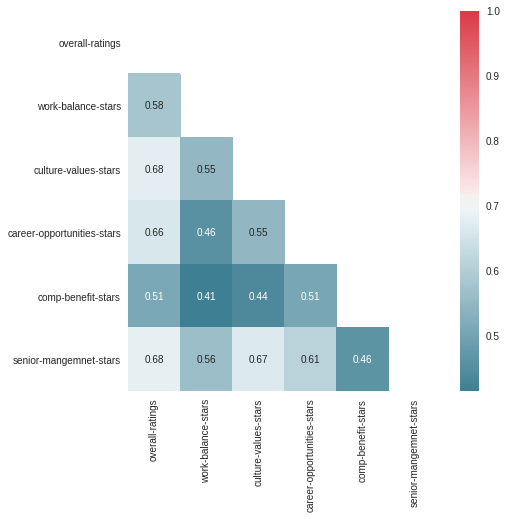

In [0]:

# Generate a mask for the upper triangle
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize = (7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask
sns.heatmap(data=df_corr, mask=mask, annot = True, cmap=cmap)

1. No one pair of rating features has a correlation higher than 0.7
2. Culture value, career opportunities and senior management have higher correlation with overall rating. Work balance and company benefit have relatively low correlation with overall rating.


### Countplot

**Number of reviews for each company**

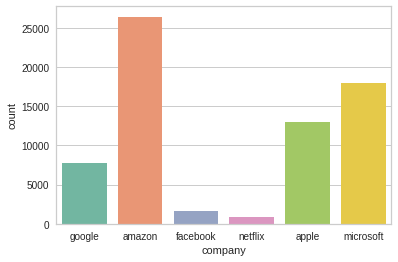

In [0]:
sns.countplot(x='company', data=df_ratings, palette ='Set2')

**2017 statistics**

Google: 88,110 full time employees 

Amazon: 566,000 full time employees

Facebook: 25,105 full time employees

Netflix: 5,400 full time employees

Apple: 123,000 full time employees

Microsoft: 124,000 full time employees

In [0]:
df_ratings.company.value_counts()

amazon       26428
microsoft    17930
apple        12949
google        7819
facebook      1590
netflix        809
Name: company, dtype: int64

In [0]:
df_ratings.location.value_counts().nlargest(20)

none                            25085
Redmond, WA                      5613
Seattle, WA                      4963
Hyderabad (India)                2149
Mountain View, CA                1706
Bengaluru (India)                1607
Cupertino, CA                    1291
New York, NY                     1152
London, England (UK)              930
Menlo Park, CA                    805
Dublin, Co. Dublin (Ireland)      723
Chennai (India)                   678
San Francisco, CA                 618
Austin, TX                        542
Bellevue, WA                      478
Los Angeles, CA                   344
Cork (Ireland)                    295
Phoenix, AZ                       290
Chicago, IL                       290
Dallas, TX                        280
Name: location, dtype: int64

**Number of reviews for each location**

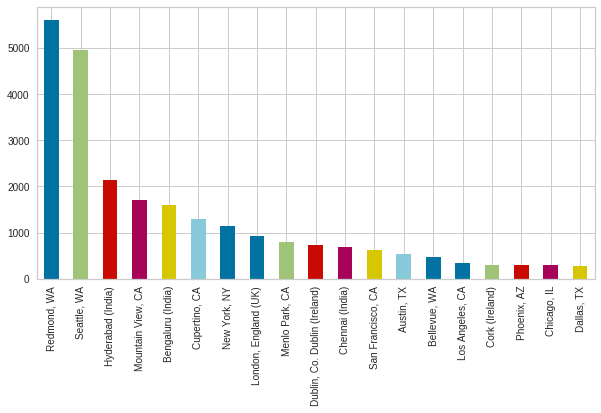

In [0]:
fig, ax= plt.subplots(figsize=(10,5))
df_ratings.location.value_counts().nlargest(20).drop("none").plot(kind='bar')

In [0]:
# find top 100 positions by review count
top_location_100 = pd.DataFrame(df_ratings.location.value_counts().nlargest(100).reset_index())
top_location_100_ls = list(top_location_100['index'].astype('str'))

# drop ' Anonymous Employee'
top_location_100_ls = [x for x in top_location_100_ls if x != 'none']

#get text from top_position column
top_location_100_df = df_ratings[df_ratings.location.isin(top_location_100_ls)]
top_location_100_text = top_location_100_df['location']
len(top_location_100_text)

33674

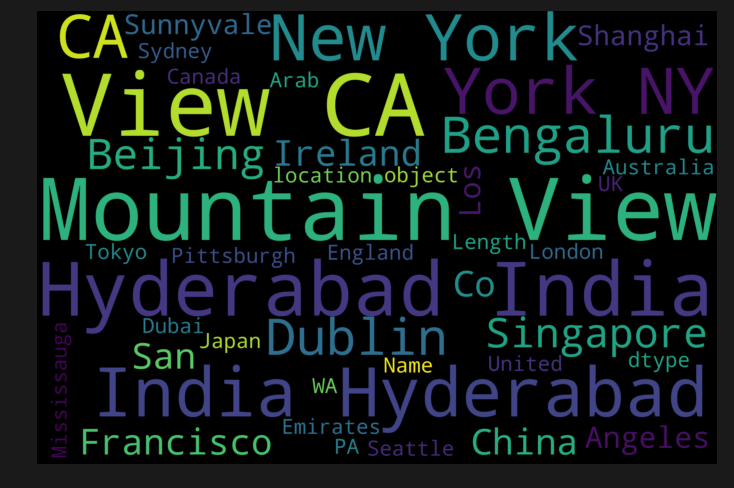

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(top_location_100_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Number of reviews over the year**

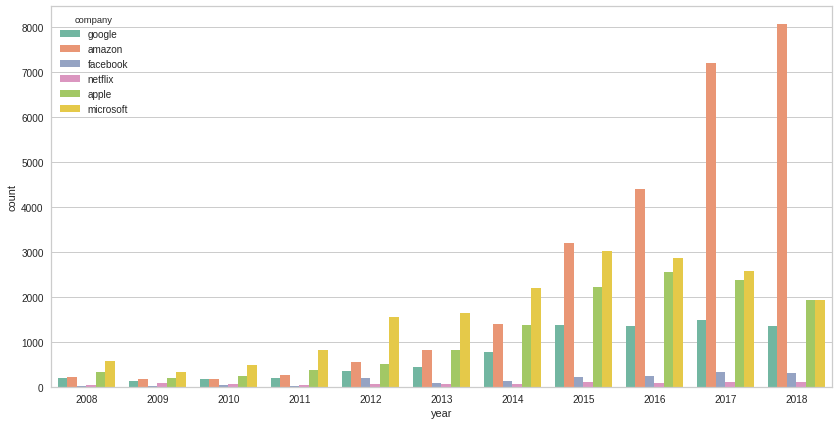

In [0]:
f,ax= plt.subplots(figsize=(14,7))
sns.countplot(x="year", hue="company", data=df_ratings, palette = 'Set2')

### Box plot

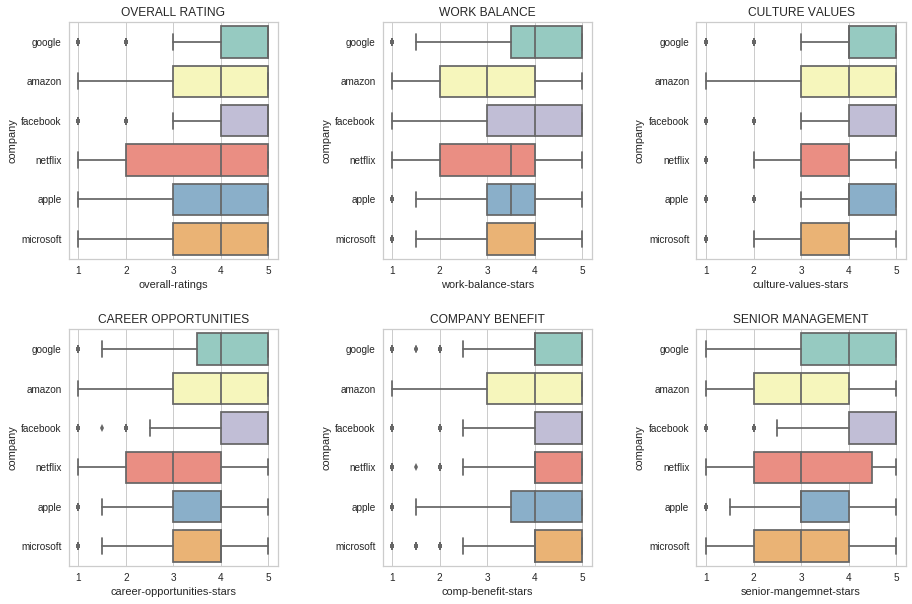

In [0]:
plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
sns.boxplot(data = df_ratings, x= 'overall-ratings', y = 'company', palette='Set3')
plt.title('OVERALL RATING')
plt.subplot(2, 3, 2)
sns.boxplot(data = df_ratings, x= 'work-balance-stars', y = 'company', palette='Set3')
plt.title('WORK BALANCE')
plt.subplot(2, 3, 3)
sns.boxplot(data = df_ratings, x= 'culture-values-stars', y = 'company', palette='Set3')
plt.title('CULTURE VALUES')
plt.subplot(2, 3, 4)
sns.boxplot(data = df_ratings, x= 'career-opportunities-stars', y = 'company', palette='Set3')
plt.title('CAREER OPPORTUNITIES')
plt.subplot(2, 3, 5)
sns.boxplot(data = df_ratings, x= 'comp-benefit-stars', y = 'company', palette='Set3')
plt.title('COMPANY BENEFIT')
plt.subplot(2, 3, 6)
sns.boxplot(data = df_ratings, x= 'senior-mangemnet-stars', y = 'company', palette='Set3')
plt.title('SENIOR MANAGEMENT')

plt.subplots_adjust(wspace = 0.5, hspace = 0.3)

1. Google and Facebook have the highest overall rating, Netflix has the lowest overall rating
2. Google and Facebook have the best work life balance, Netflix and Amazon have the worst work life balance.
3. Netflix and Microsoft have the lowest rating for culture values
4. Netflix has the worst rating for career opportunities

**Current employee v.s. Former employee**

In [0]:
import plotly.plotly as py
from plotly.offline import iplot
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode
enable_plotly_in_cell()


# function for extracting 'current employee'/'former employee' from job-title
def find_employee_type(s):
    x = re.search(r'([^-]*)-',s).group(1)
    return str(x)
  
# create a new column employee_status   
df_ratings['employee_type'] = df_ratings['job-title'].apply(find_employee_type)

# reshape data for visualization
cmp_lc= df_ratings[["company","employee_type"]] 
cmp_lc = cmp_lc.groupby(["company", "employee_type"]).size().reset_index()
cmp_lc = cmp_lc.rename(columns={0: 'total_reviews_by_title'})

company = list(cmp_lc.company.unique())
company_data = []
v = True

for i in company:
    if i!='amazon':
        v=False
    data_upd = [dict(type='bar',
                     visible = v,
                     x = cmp_lc[cmp_lc['company']==i]['employee_type'],
                     y = cmp_lc[cmp_lc['company']==i]['total_reviews_by_title'],
                     textposition = 'auto',
                     marker=dict(
                     color='rgb(158,202,225)',
                     line=dict(
                         color='rgb(8,48,107)',
                         width=1.5),
                     ),
                 opacity=0.6)]
    
    company_data.extend(data_upd)

company = [x.capitalize() for x in company]

# set menus inside the plot
steps = []
comp = 0
for i in range(0,len(company_data)):
    step = dict(method = "restyle",
                args = ["visible", [False]*len(company_data)],
                label = company[comp]) 
    step['args'][1][i] = True
    steps.append(step)
    comp += 1
    

sliders = [dict(active = 6,
                currentvalue = {"prefix": "Company: "},
                pad = {"t": 50},
                steps = steps)]

# Set the layout
layout = dict(title = 'Do current employees review the comapnies more than the ex-employees?',
              sliders = sliders)

fig = dict(data=company_data, layout=layout)
iplot(fig)

**Amazon**

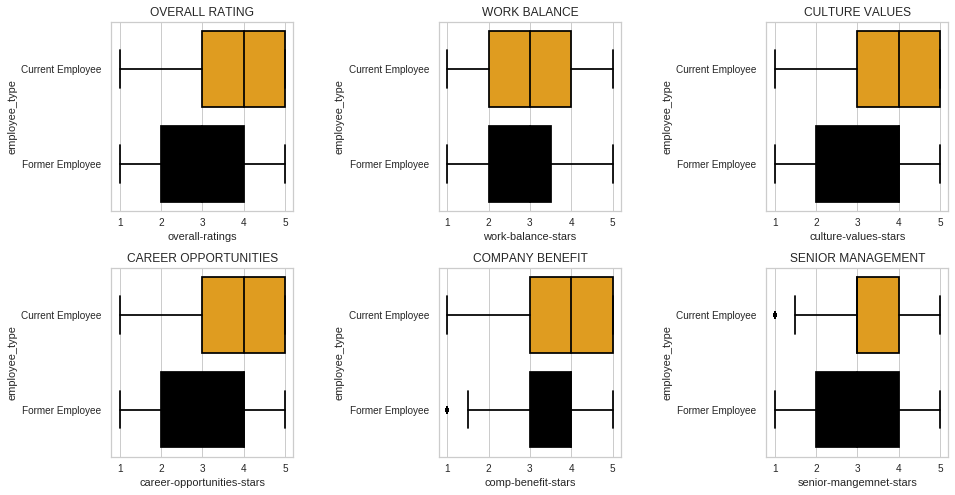

In [0]:
df_amazon = df_ratings[df_ratings['company']=='amazon']

plt.figure(figsize=(15,8))

plt.subplot(2, 3, 1)
my_pal = {"Current Employee ": "orange", "Former Employee ": "black"}         
ax = sns.boxplot(data=df_amazon, y='employee_type', x='overall-ratings', palette=my_pal)
plt.title('OVERALL RATING')

plt.subplot(2, 3, 2)
ax = sns.boxplot(data=df_amazon, y='employee_type', x='work-balance-stars', palette=my_pal)
plt.title('WORK BALANCE')

plt.subplot(2, 3, 3)
ax = sns.boxplot(data=df_amazon, y='employee_type', x='culture-values-stars', palette=my_pal)
plt.title('CULTURE VALUES')

plt.subplot(2, 3, 4)
ax = sns.boxplot(data=df_amazon, y='employee_type', x='career-opportunities-stars', palette=my_pal)
plt.title('CAREER OPPORTUNITIES')

plt.subplot(2, 3, 5)
ax = sns.boxplot(data=df_amazon, y='employee_type', x='comp-benefit-stars', palette=my_pal)
plt.title('COMPANY BENEFIT')

plt.subplot(2, 3, 6)
ax = sns.boxplot(data=df_amazon, y='employee_type', x='senior-mangemnet-stars', palette=my_pal)
plt.title('SENIOR MANAGEMENT')

plt.subplots_adjust(wspace = 0.8, hspace = 0.3)

**Netflix**

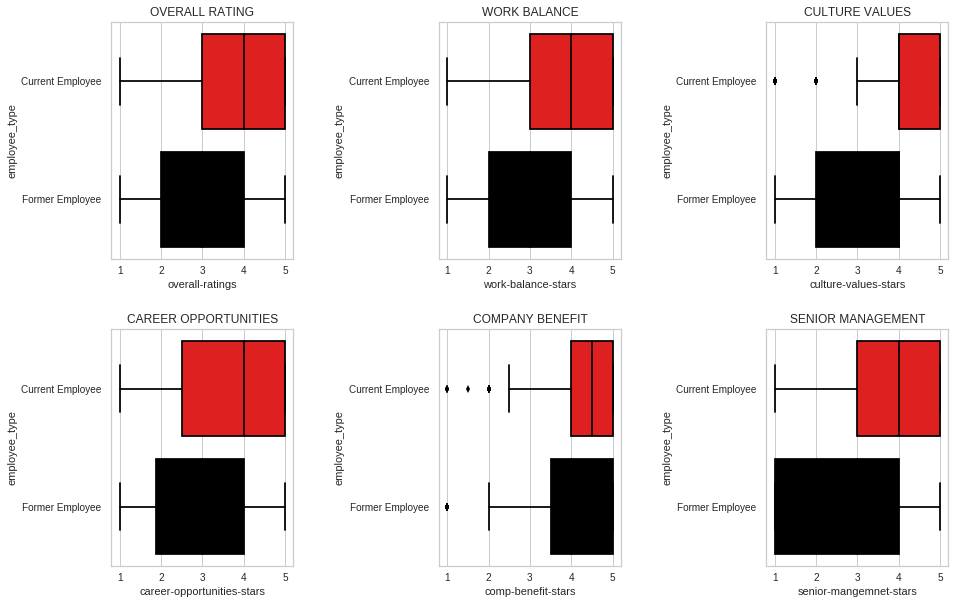

In [0]:
df_netflix = df_ratings[df_ratings['company']=='netflix']

plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
my_pal = {"Current Employee ": "red", "Former Employee ": "black"}
ax = sns.boxplot(data=df_netflix, y='employee_type', x='overall-ratings', palette=my_pal)
plt.title('OVERALL RATING')


plt.subplot(2, 3, 2)
ax = sns.boxplot(data=df_netflix, y='employee_type', x='work-balance-stars', palette=my_pal)
plt.title('WORK BALANCE')

plt.subplot(2, 3, 3)
ax = sns.boxplot(data=df_netflix, y='employee_type', x='culture-values-stars', palette=my_pal)
plt.title('CULTURE VALUES')

plt.subplot(2, 3, 4)
ax = sns.boxplot(data=df_netflix, y='employee_type', x='career-opportunities-stars', palette=my_pal)
plt.title('CAREER OPPORTUNITIES')

plt.subplot(2, 3, 5)
ax = sns.boxplot(data=df_netflix, y='employee_type', x='comp-benefit-stars', palette=my_pal)
plt.title('COMPANY BENEFIT')

plt.subplot(2, 3, 6)
ax = sns.boxplot(data=df_netflix, y='employee_type', x='senior-mangemnet-stars', palette=my_pal)
plt.title('SENIOR MANAGEMENT')

plt.subplots_adjust(wspace = 0.8, hspace = 0.3)

**Facebook**

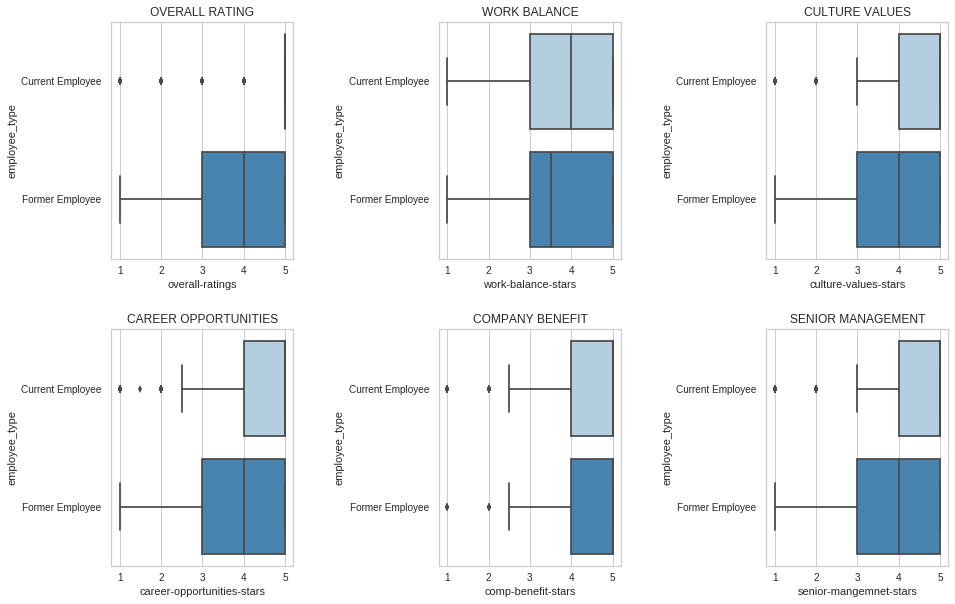

In [0]:
df_facebook = df_ratings[df_ratings['company']=='facebook']

plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
ax = sns.boxplot(data=df_facebook, y='employee_type', x='overall-ratings', palette="Blues")
plt.title('OVERALL RATING')

plt.subplot(2, 3, 2)
ax = sns.boxplot(data=df_facebook, y='employee_type', x='work-balance-stars', palette="Blues")
plt.title('WORK BALANCE')

plt.subplot(2, 3, 3)
ax = sns.boxplot(data=df_facebook, y='employee_type', x='culture-values-stars', palette="Blues")
plt.title('CULTURE VALUES')

plt.subplot(2, 3, 4)
ax = sns.boxplot(data=df_facebook, y='employee_type', x='career-opportunities-stars', palette="Blues")
plt.title('CAREER OPPORTUNITIES')

plt.subplot(2, 3, 5)
ax = sns.boxplot(data=df_facebook, y='employee_type', x='comp-benefit-stars', palette="Blues")
plt.title('COMPANY BENEFIT')

plt.subplot(2, 3, 6)
ax = sns.boxplot(data=df_facebook, y='employee_type', x='senior-mangemnet-stars',palette="Blues")
plt.title('SENIOR MANAGEMENT')

plt.subplots_adjust(wspace = 0.8, hspace = 0.3)

**Google**

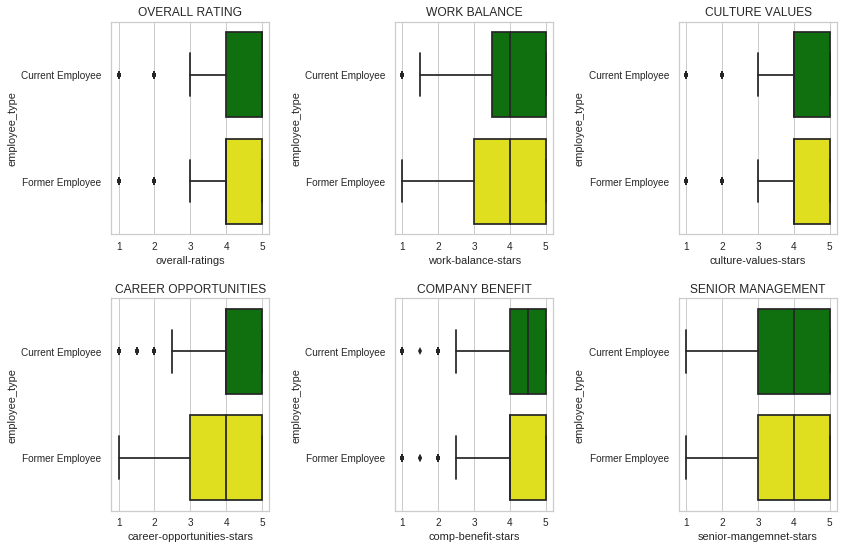

In [0]:
df_google = df_ratings[df_ratings['company']=='google']

plt.figure(figsize=(13,9))
my_pal = {"Current Employee ": "green", "Former Employee ": "yellow"}

plt.subplot(2, 3, 1)
ax = sns.boxplot(data=df_google, y='employee_type', x='overall-ratings', palette=my_pal)
plt.title('OVERALL RATING')

plt.subplot(2, 3, 2)
ax = sns.boxplot(data=df_google, y='employee_type', x='work-balance-stars', palette=my_pal)
plt.title('WORK BALANCE')

plt.subplot(2, 3, 3)
ax = sns.boxplot(data=df_google, y='employee_type', x='culture-values-stars', palette=my_pal)
plt.title('CULTURE VALUES')

plt.subplot(2, 3, 4)
ax = sns.boxplot(data=df_google, y='employee_type', x='career-opportunities-stars', palette=my_pal)
plt.title('CAREER OPPORTUNITIES')

plt.subplot(2, 3, 5)
ax = sns.boxplot(data=df_google, y='employee_type', x='comp-benefit-stars', palette=my_pal)
plt.title('COMPANY BENEFIT')

plt.subplot(2, 3, 6)
ax = sns.boxplot(data=df_google, y='employee_type', x='senior-mangemnet-stars', palette=my_pal)
plt.title('SENIOR MANAGEMENT')

plt.subplots_adjust(wspace = 0.8, hspace = 0.3)

In [0]:
# extract 'position' from job-title
split = df_ratings["job-title"].str.split("-", expand=True)
df_ratings['position'] = split[1]
top_position = df_ratings.position.value_counts().nlargest(20).reset_index()
top_position.rename(columns={'index': 'top_position', 'position':'review_count'}, inplace=True)
top_position.drop(index = 0, inplace=True)

#f,ax = plt.subplots(figsize=(10,6))
#sns.barplot(x='top_position', y = 'review_count', data=top_position)
#ax.legend(loc='best')
#ax.set_xlabel('')


In [0]:
# find top 100 positions by review count
top_position_100 = pd.DataFrame(df_ratings.position.value_counts().nlargest(100).reset_index())
top_position_100_ls = list(top_position_100['index'].astype('str'))

# drop ' Anonymous Employee'
top_position_100_ls = [x for x in top_position_100_ls if x != ' Anonymous Employee']

# get text from top_position column
top_position_100_df = df_ratings[df_ratings.position.isin(top_position_100_ls)]
top_position_100_text = top_position_100_df['position']
len(top_position_100_text)

21479

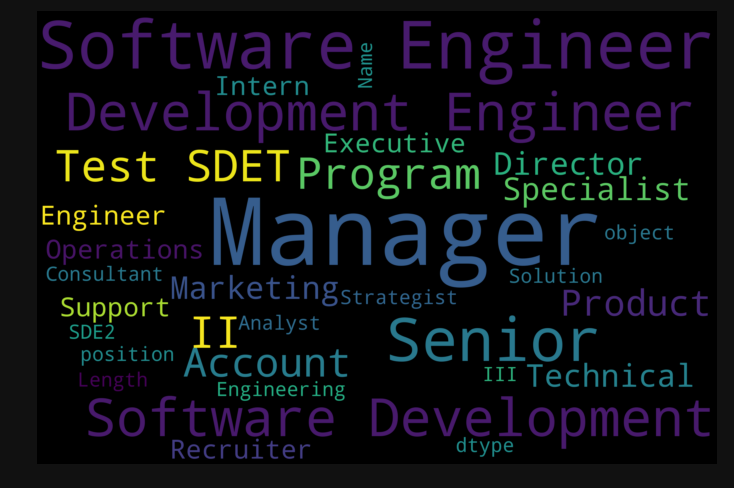

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(top_position_100_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

No handles with labels found to put in legend.


Text(0.5, 3.200000000000003, '')

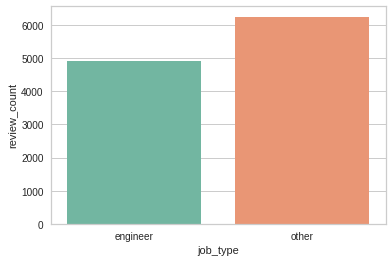

In [0]:
top_position= top_position.assign(job_type ='other')
top_position.loc[top_position.top_position.str.contains('Engineer'), 'job_type']= 'engineer'
top_position.loc[top_position.top_position.str.contains('Developer'), 'job_type']= 'engineer'
job_type= top_position[['job_type','review_count']].groupby('job_type').sum()

job_type.reset_index(inplace=True)

sns.barplot(x='job_type', y = 'review_count', data=job_type, palette ='Set2')
ax.legend(loc='best')
ax.set_xlabel('')

In [0]:
df_ratings = df_ratings.assign(job_type ='other')
df_ratings.loc[df_ratings.position.str.contains('Engineer'), 'job_type']= 'engineer'
df_ratings.loc[df_ratings.position.str.contains('Developer'), 'job_type']= 'engineer'

df_ratings.loc[df_ratings.position.str.contains('Finance'), 'job_type']= 'business'
df_ratings.loc[df_ratings.position.str.contains('Financial'), 'job_type']= 'business'
df_ratings.loc[df_ratings.position.str.contains('Product'), 'job_type']= 'business'
df_ratings.loc[df_ratings.position.str.contains('Operations'), 'job_type']= 'business'
df_ratings.loc[df_ratings.position.str.contains('Marketing'), 'job_type']= 'business'
df_ratings.loc[df_ratings.position.str.contains('Business'), 'job_type']= 'business'
df_ratings.loc[df_ratings.position.str.contains('Recruiter'), 'job_type']= 'business'
df_ratings.loc[df_ratings.position.str.contains('Consultant'), 'job_type']= 'business'

df_ratings.loc[df_ratings.position.str.contains('Manager'), 'job_type']= 'management'
df_ratings.loc[df_ratings.position.str.contains('Director'), 'job_type']= 'management'

df_ratings.loc[df_ratings.position.str.contains('Sales'), 'job_type']= 'business'
df_ratings.loc[df_ratings.position.str.contains('Account Executive'), 'job_type']= 'business'

In [0]:
df_job_type = df_ratings.drop(df_ratings[df_ratings.job_type == 'other'].index, axis=0)

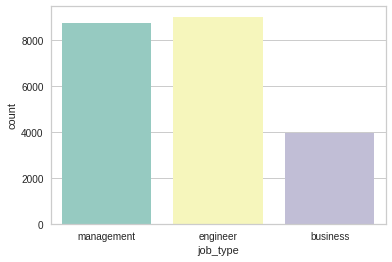

In [0]:
sns.countplot(x='job_type', data = df_job_type, palette='Set3')

In [0]:
df_ratings=df_ratings.assign(country='other')
df_ratings.loc[df_ratings.location.str.contains(','), 'country']= 'US'
df_ratings.loc[df_ratings.location.str.contains('none'), 'country']= 'none'

In [0]:
df_country = df_ratings.drop(df_ratings[df_ratings.country=='none'].index)

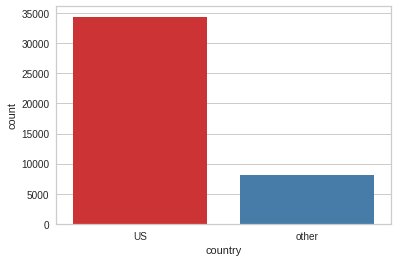

In [0]:
sns.countplot(x='country', data=df_country, palette ='Set1')

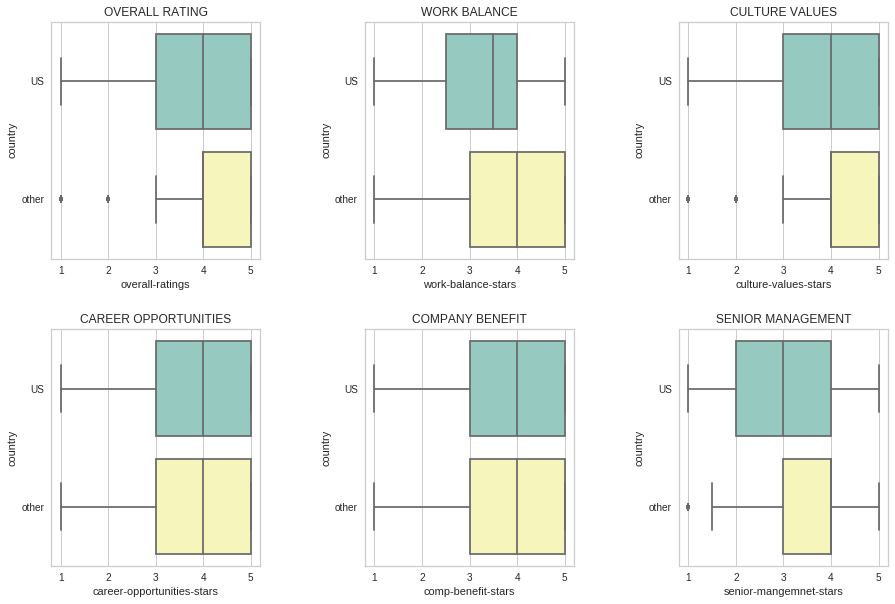

In [0]:
plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
sns.boxplot(y='country', x='overall-ratings', data=df_country, palette ='Set3')
plt.title('OVERALL RATING')
plt.subplot(2, 3, 2)
sns.boxplot(data = df_country, x= 'work-balance-stars', y='country', palette='Set3')
plt.title('WORK BALANCE')
plt.subplot(2, 3, 3)
sns.boxplot(data = df_country, x= 'culture-values-stars', y='country', palette='Set3')
plt.title('CULTURE VALUES')
plt.subplot(2, 3, 4)
sns.boxplot(data = df_country, x= 'career-opportunities-stars', y='country', palette='Set3')
plt.title('CAREER OPPORTUNITIES')
plt.subplot(2, 3, 5)
sns.boxplot(data = df_country, x= 'comp-benefit-stars', y='country', palette='Set3')
plt.title('COMPANY BENEFIT')
plt.subplot(2, 3, 6)
sns.boxplot(data = df_country, x= 'senior-mangemnet-stars', y='country', palette='Set3')
plt.title('SENIOR MANAGEMENT')

plt.subplots_adjust(wspace = 0.5, hspace = 0.3)


## Modeling

### Preprocessing

In [0]:
# extract 'position' from job-title
split = df["job-title"].str.split("-", expand=True)
df['position'] = split[1]

In [0]:
# extract 'employee_status' from job-title
split = df["job-title"].str.split("-", expand=True)
df['employee_type'] = split[0]

In [0]:
# categorize job-title as job_type
df = df.assign(job_type ='other')
df.loc[df.position.str.contains('Engineer'), 'job_type']= 'engineer'
df.loc[df.position.str.contains('Developer'), 'job_type']= 'engineer'

df.loc[df.position.str.contains('Finance'), 'job_type']= 'business'
df.loc[df.position.str.contains('Financial'), 'job_type']= 'business'
df.loc[df.position.str.contains('Product'), 'job_type']= 'business'
df.loc[df.position.str.contains('Operations'), 'job_type']= 'business'
df.loc[df.position.str.contains('Marketing'), 'job_type']= 'business'
df.loc[df.position.str.contains('Business'), 'job_type']= 'business'
df.loc[df.position.str.contains('Recruiter'), 'job_type']= 'business'
df.loc[df.position.str.contains('Consultant'), 'job_type']= 'business'

df.loc[df.position.str.contains('Manager'), 'job_type']= 'management'
df.loc[df.position.str.contains('Director'), 'job_type']= 'management'

df.loc[df.position.str.contains('Sales'), 'job_type']= 'sales'
df.loc[df.position.str.contains('Account Executive'), 'job_type']= 'sales'

In [0]:
df=df.assign(country='other')
df.loc[df.location.str.contains(','), 'country']= 'US'
df.loc[df.location.str.contains('none'), 'country']= 'none'

In [0]:
df_modeling=df.copy()

In [0]:
df.head(2)

company           location      dates  \
0  google               none 2018-12-11   
1  google  Mountain View, CA 2013-06-21   

                               job-title  \
0  Current Employee - Anonymous Employee   
1      Former Employee - Program Manager   

                                             summary  \
0                           Best Company to work for   
1  Moving at the speed of light, burn out is inev...   

                                                pros  \
0                      People are smart and friendly   
1  1) Food, food, food. 15+ cafes on main campus ...   

                                                cons  \
0                 Bureaucracy is slowing things down   
1  1) Work/life balance. What balance? All those ...   

                                      advice-to-mgmt  overall-ratings  \
0                                               none              5.0   
1  1) Don't dismiss emotional intelligence and ad...              4.0   

   work-balance-stars  culture-values-stars  career-opportunities-stars  \
0                 4.0                   5.0                         5.0   
1                 2.0                   3.0                         3.0   

   comp-benefit-stars  senior-mangemnet-stars  helpful-count  \
0                 4.0                     5.0            0.0   
1                 5.0                     3.0         2094.0   

              position      employee_type    job_type country  
0   Anonymous Employee  Current Employee        other    none  
1      Program Manager   Former Employee   management      US

### Encode categorical variables

In [0]:
# store encoder in dictionary
d = defaultdict(LabelEncoder)

# Encoding the variable
encode = ['company', 'employee_type', 'job_type', 'country']
fit = df_modeling[encode].apply(lambda x: d[x.name].fit_transform(x))
df_modeling[encode] = fit

### Scale rating data

In [0]:
scaler = StandardScaler()

columns = ['overall-ratings', 'work-balance-stars',
           'culture-values-stars', 'career-opportunities-stars',
           'comp-benefit-stars', 'senior-mangemnet-stars']

scaled_ratings =scaler.fit_transform(df_modeling[columns])
scaled_df = pd.DataFrame(scaled_ratings, columns=columns)
df_modeling[columns] = scaled_df[columns]

In [0]:
df_modeling.fillna(0, inplace=True)
df_modeling.dropna(inplace=True)

In [0]:
df_modeling.columns

Index(['company', 'location', 'dates', 'job-title', 'summary', 'pros', 'cons',
       'advice-to-mgmt', 'overall-ratings', 'work-balance-stars',
       'culture-values-stars', 'career-opportunities-stars',
       'comp-benefit-stars', 'senior-mangemnet-stars', 'helpful-count',
       'position', 'employee_type', 'job_type', 'country'],
      dtype='object')

In [0]:
df_modeling = df_modeling.drop(['company', 'location', 'dates', 'job-title',
                                'summary', 'pros', 'cons','advice-to-mgmt', 
                                'position', 'helpful-count'], axis=1)

In [0]:
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67525 entries, 0 to 67528
Data columns (total 9 columns):
overall-ratings               67525 non-null float64
work-balance-stars            67525 non-null float64
culture-values-stars          67525 non-null float64
career-opportunities-stars    67525 non-null float64
comp-benefit-stars            67525 non-null float64
senior-mangemnet-stars        67525 non-null float64
employee_type                 67525 non-null int64
job_type                      67525 non-null int64
country                       67525 non-null int64
dtypes: float64(6), int64(3)
memory usage: 5.2 MB


### Dimensionality reduction

In [0]:
#visualizer = PCADecomposition(proj_features=True, proj_dim=3)
#visualizer.fit_transform(df_modeling)
#visualizer.poof()

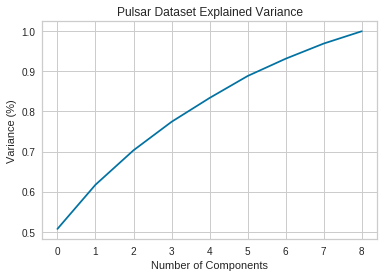

In [0]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(df_modeling)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

3 components can explain 80% variance, 5 components can explain 90% variance

### clustering

In [0]:
# dimension reduction - retain 5 components
pca = PCA(n_components = 5)
principal_component = pca.fit_transform(df_modeling)

# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(principal_component, quantile=0.2, n_samples=10000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(principal_component)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


number of estimated clusters : 1


In [0]:
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(df_modeling, quantile=0.2, n_samples=10000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df_modeling)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


number of estimated clusters : 1


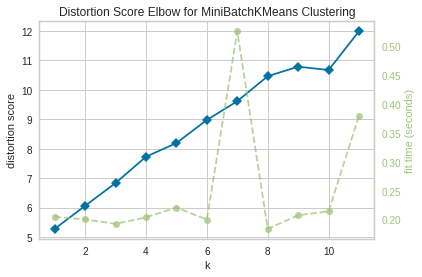

In [0]:
# dimension reduction - retain 3 components
pca = PCA(n_components = 3)
principal_component = pca.fit_transform(df_modeling)

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(principal_component)    # Fit the data to the visualizer
visualizer.poof()                      # show graph

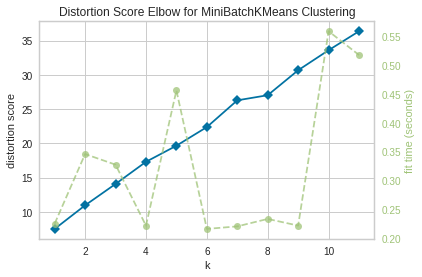

In [0]:
# Instantiate the clustering model and visualizer
model = MiniBatchKMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(df_modeling)    # Fit the data to the visualizer
visualizer.poof()                      # show graph

### classification

In [0]:
df_modeling.head()

overall-ratings  work-balance-stars  culture-values-stars  \
0         1.016403            0.498729              1.008756   
1         0.150606           -1.127731             -0.712242   
2         1.016403            1.311958              0.148257   
3         1.016403           -1.127731              1.008756   
4         1.016403            1.311958              1.008756   

   career-opportunities-stars  comp-benefit-stars  senior-mangemnet-stars  \
0                    1.139537            0.052338                1.384041   
1                   -0.577345            1.070527               -0.230369   
2                    1.139537            1.070527                0.576836   
3                    1.139537            0.052338                1.384041   
4                    1.139537            1.070527                1.384041   

   employee_type  job_type  country  
0              0         3        1  
1              1         2        0  
2              0         1        0  
3              0         3        0  
4              1         1        0

In [0]:
X = df_modeling.drop(['employee_type'], axis=1)
y = df_modeling.employee_type

In [0]:
y.shape

(67525,)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

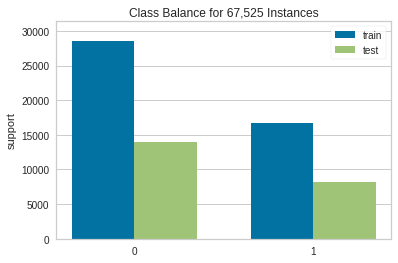

In [0]:
# make sure consistent class distribution between training and test sets:
visualizer = ClassBalance(labels=[0,1])

visualizer.fit(y_train_vis, y_test_vis)
visualizer.poof()

**LinearSVC**

In [0]:
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test)
y_predict = clf.predict(X_test)

In [0]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Average precision-recall score: 0.41


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.41')

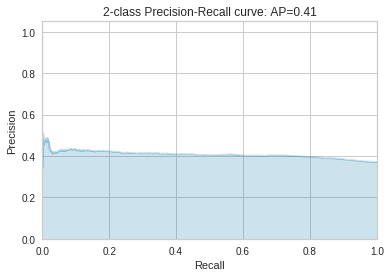

In [0]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [0]:
print(classification_report(y_test, y_predict, target_names=['no_churn', 'churn']))

              precision    recall  f1-score   support

    no_churn       0.63      1.00      0.77     14021
       churn       0.40      0.00      0.00      8263

   micro avg       0.63      0.63      0.63     22284
   macro avg       0.51      0.50      0.39     22284
weighted avg       0.54      0.63      0.49     22284



In [0]:
# Inverse the encoded
# fit.apply(lambda x: d[x.name].inverse_transform(x))

**Logistic Regression**

In [0]:
y_test_vis = np.reshape(y_test, 22284)
y_train_vis = np.reshape(y_train, 45241)

In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77     14021
           1       0.42      0.00      0.00      8263

   micro avg       0.63      0.63      0.63     22284
   macro avg       0.52      0.50      0.39     22284
weighted avg       0.55      0.63      0.49     22284



In [0]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77     14021
           1       0.00      0.00      0.00      8263

   micro avg       0.63      0.63      0.63     22284
   macro avg       0.31      0.50      0.39     22284
weighted avg       0.40      0.63      0.49     22284



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [0]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.3, random_state=42)

In [0]:
clf_1 = LinearSVC(random_state=0, tol=1e-5)
clf_1.fit(X_train_1, y_train_1)
y_score_1 = clf.decision_function(X_test_1)
y_predict_1 = clf.predict(X_test_1)
print(classification_report(y_test_1, y_predict_1, target_names=['no_churn', 'churn']))

              precision    recall  f1-score   support

    no_churn       0.63      1.00      0.77     12742
       churn       0.50      0.00      0.00      7516

   micro avg       0.63      0.63      0.63     20258
   macro avg       0.56      0.50      0.39     20258
weighted avg       0.58      0.63      0.49     20258



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [0]:
clf_1 = LogisticRegression(random_state=0, class_weight='balanced')
clf_1.fit(X_train_1, y_train_1)
y_score_1 = clf.decision_function(X_test_1)
y_predict_1 = clf.predict(X_test_1)
print(classification_report(y_test_1, y_predict_1, target_names=['no_churn', 'churn']))

              precision    recall  f1-score   support

    no_churn       0.63      1.00      0.77     16998
       churn       0.50      0.00      0.00     10012

   micro avg       0.63      0.63      0.63     27010
   macro avg       0.56      0.50      0.39     27010
weighted avg       0.58      0.63      0.49     27010



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [0]:
clf_1 = LogisticRegressionCV(cv=5, random_state=0,class_weight='balanced')
clf_1.fit(X_train_1, y_train_1)
y_score_1 = clf.decision_function(X_test_1)
y_predict_1 = clf.predict(X_test_1)
print(classification_report(y_test_1, y_predict_1, target_names=['no_churn', 'churn']))

              precision    recall  f1-score   support

    no_churn       0.63      1.00      0.77     16998
       churn       0.50      0.00      0.00     10012

   micro avg       0.63      0.63      0.63     27010
   macro avg       0.56      0.50      0.39     27010
weighted avg       0.58      0.63      0.49     27010



## Tuning Model 

### GridSearchCV 
Using GridSearchCV to tune model by searching for the best hyperparameters and keeping the classifier with the highest recall score.

In [0]:
# use RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1)

# set tunable parameters
param_grid = {
    'min_samples_split': [3, 5, 10], 
    'max_depth': [3, 5, 15],
    'max_features': [3, 5, 8]
}

# set scores
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

# fuction is to optimize recall-score
def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_no_churn', 'pred_churn'], index=['no_churn', 'churn']))
    return grid_search

grid_search_clf = grid_search_wrapper(refit_score='recall_score')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:740: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Best params for recall_score
{'max_depth': 15, 'max_features': 8, 'min_samples_split': 3}

Confusion matrix of Random Forest optimized for recall_score on the test data:
          pred_no_churn  pred_churn
no_churn          12479        1542
churn              7278         985


In [0]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 
         'param_max_depth', 'param_max_features', 'param_min_samples_split']].round(3).head()

mean_test_precision_score  mean_test_recall_score  \
24                      0.388                   0.131   
25                      0.395                   0.122   
21                      0.398                   0.119   
26                      0.402                   0.114   
22                      0.395                   0.112   

    mean_test_accuracy_score param_max_depth param_max_features  \
24                     0.602              15                  8   
25                     0.606              15                  8   
21                     0.608              15                  5   
26                     0.610              15                  8   
22                     0.608              15                  5   

   param_min_samples_split  
24                       3  
25                       5  
21                       3  
26                      10  
22                       5

### Finetuning decision threshold
visualize the sensitivity-specificty tradeoff in the classifier

In [0]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)
p, r, thresholds

(array([0.37080416, 0.37086986, 0.37081329, ..., 0.28571429, 0.25      ,
        1.        ]),
 array([1.00000000e+00, 9.98426722e-01, 9.98184679e-01, ...,
        2.42042842e-04, 1.21021421e-04, 0.00000000e+00]),
 array([0.        , 0.00487805, 0.005     , ..., 0.945     , 0.95      ,
        1.        ]))

0.5323308022182076


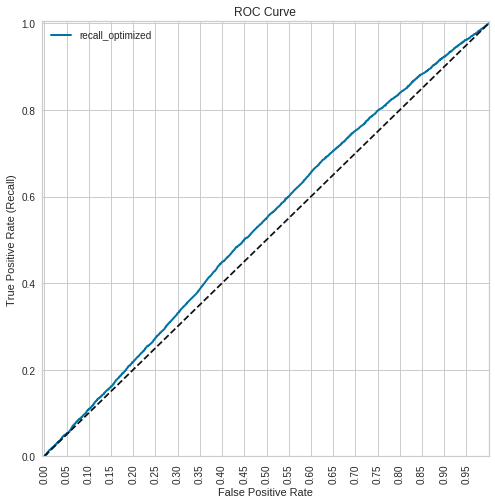

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
  
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [0]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.3):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_no_churn', 'pred_churn'], 
                       index=['no_churn', 'churn']))

precision_recall_threshold(p, r, thresholds, 0.4)

          pred_no_churn  pred_churn
no_churn           8274        5747
churn              4485        3778


## Conclustion

**Takeaway**
1. Scalability of MeanShift:
The complexity will tend towards O(T*n*log(n)) in lower dimensions, with n the number of samples and T the number of points. In higher dimensions the complexity will tend towards O(T*n^2).

**Next Step**
1. Try different imputation method.
2. Balance number of observations for each company.
3. Analyze U.S. data only.
4. Sentiment analysis.
5. Feature selection: bring text into classification (Naive Bayes).